### Whale Sound Mining

In this tutorial we will explore some data which contain right whale calls. The dataset was shared as part of a [2013 Kaggle competition](https://www.kaggle.com/c/whale-detection-challenge). Our goal is not to show the best winning algorithm to detect a call, but share a simple pipeline for processing oscillatory data, which possibly can be used on wide range of time series.

Objectives:
* read and extract features form audio data
* apply dimensionality reduction techinques
* unsupervised clustering 
* supervised classification


In [7]:
# importing multiple visualization libraries
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab as pl
import seaborn

In [8]:
# importing libraries to manipulate the data files
import os
from glob import glob

In [9]:
# import a library to read the .aiff format
import aifc

The `train` folder contains many `.aiff` files (2 second snippets) and we have `.csv` document which contains the corresponding labels. 

In [10]:
!ls whale_data

test      test.csv  train     train.csv


In [11]:
filenames = glob(os.path.join('whale_data','train','*.aiff'))

In [12]:
print('There are '+str(len(filenames))+' files.' )

There are 30000 files.


In [13]:
# read the labels
import pandas as pd
labels = pd.read_csv(os.path.join('whale_data','train.csv'), index_col = 0)

The format of the labels is

In [14]:
labels.head()

,label
clip_name,
train1.aiff,0
train2.aiff,0
train3.aiff,0
train4.aiff,0
train5.aiff,0


In [15]:
# filenames which contain calls
whale_labels = labels[labels['label'] == 1].index

In [16]:
whale_labels[0]

'train6.aiff'

In [17]:
print('There are '+str(len(whale_labels))+' calls.')

There are 7027 calls.


Let's look at one of those files.

In [18]:
# reading the file info
whale_sample_file = whale_labels[20] 
whale_aiff = aifc.open(os.path.join('whale_data','train',whale_sample_file),'r')
print ("Frames:", whale_aiff.getnframes() )
print ("Frame rate (frames per second):", whale_aiff.getframerate())

Frames: 4000
Frame rate (frames per second): 2000


/Users/valentina/anaconda/envs/ohw_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


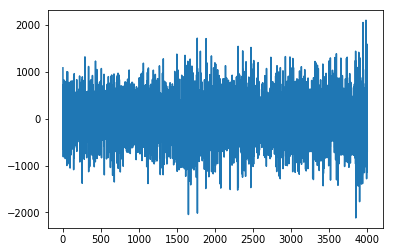

In [19]:
# reading the data
whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
whale_array = np.fromstring(whale_strSig, np.short).byteswap()
plt.plot(whale_array)

Working directly with the signals is hard (there is important frequency information). Let's calculate the spectrogram for each of the signals and use them as features.

In [20]:
# a function for plotting histograms
def PlotSpecgram(P, freqs, bins):
    """Spectrogram"""
    Z = np.flipud(P) # flip rows so that top goes to bottom, bottom to top, etc.
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]

    im = pl.imshow(Z, extent=extent,cmap='viridis')
    pl.axis('auto')
    pl.xlim([0.0, bins[-1]])
    pl.ylim([0, freqs[-1]])

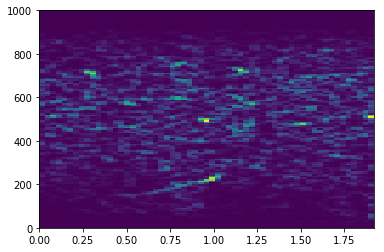

In [21]:
params = {'NFFT':256, 'Fs':2000, 'noverlap':192}
P, freqs, bins = mlab.specgram(whale_array, **params)
PlotSpecgram(P, freqs, bins)

In [22]:
P.shape

(129, 59)

In [23]:
# create a dictionary which contains all the spectrograms
spec_dict = {}

In [24]:
# cutting the higher frequencies ([:60,:])
for filename in filenames[::1]:
    aiff = aifc.open(filename,'r')
    whale_strSig = aiff.readframes(aiff.getnframes())
    whale_array = np.fromstring(whale_strSig, np.short).byteswap()
    P, freqs, bins = mlab.specgram(whale_array, **params)
    spec_dict[filename] = P[:60,:]
    
    

/Users/valentina/anaconda/envs/ohw_tutorial/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """


Most machine learning algorithms in Python expect the data to come in a format features x samples.

In [25]:
# The key below depends on the directory structure
feature_dict = {}
for key in filenames[::1]:
    feature_dict[key[17:]] = spec_dict[key].ravel()

In [26]:
X = pd.DataFrame(feature_dict)

In [27]:
del feature_dict
del spec_dict

In [28]:
X.shape

(3540, 30000)

### Dimensionality Reduction

We can now represent each signal with its spectrogram, which can be treated as a high dimensional vector. However, we can try to look for common patterns in those spectrograms and attempt to represent them with fewer dimensions. This can be accomplished by linear dimenionsality techniques such as Principal Component Analysis (PCA) and Independent Component Analysis (ICA). These techniques are easy to apply with the Python's `scikit-learn` library.

#### PCA

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30,copy=True)
X_transformed = pca.fit_transform(X.iloc[:,:].T)

The resulting dimensions are:

In [30]:
X_transformed.shape

(30000, 30)

Why did I pick 30 components?

Text(0.5,1,'Singular values')

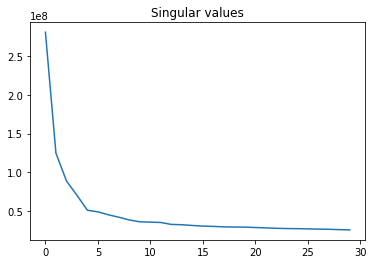

In [31]:
plt.plot(pca.singular_values_)
plt.title("Singular values")

In [32]:
pca.components_.shape

(30, 3540)

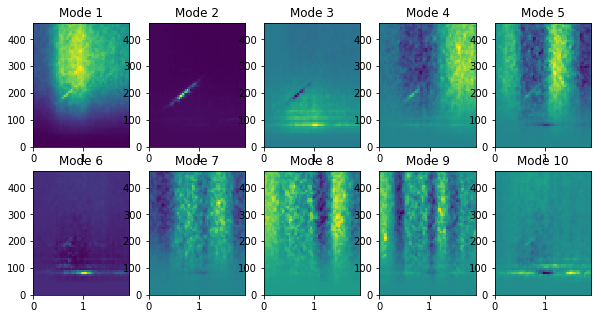

In [33]:
# plot first ten components
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    u = pca.components_[i,:].reshape(-1,59)
    #plt.imshow((u-u.min())/(u.max() - u.min()))
    PlotSpecgram(u,freqs[:60],bins)
    plt.title('Mode '+str(i+1))

#### ICA

In [36]:
# ICA is expensive: we will look for 5 components
# free some ram
del X_transformed
# run ica
from sklearn.decomposition import FastICA
ica = FastICA(n_components=5)
X_transformed = ica.fit(X.T).transform(X.T)

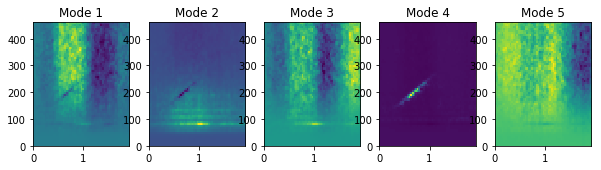

In [37]:
# plot first 3 components
plt.figure(figsize = (10,5))
for i in range(5):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    u = ica.components_[i,:].reshape(-1,59)
    plt.imshow((u-u.min())/(u.max() - u.min()))
    PlotSpecgram(u,freqs[:60],bins)
    plt.title('Mode '+str(i+1))

#### Unsupervised Clustering

Let's try to cluster the data and visualize in 2D.

In [38]:
from sklearn.cluster import KMeans

In [39]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_transformed)

In [40]:
# kmeans.labels_

In [41]:
# create a list of colors
colors = []
for c in labels['label'][X.columns]:
    if c==1:
        colors.append('red')
    else:
        colors.append('cyan')

Text(0.5,1,'Projection of the data on 2 components - ground truth labels')

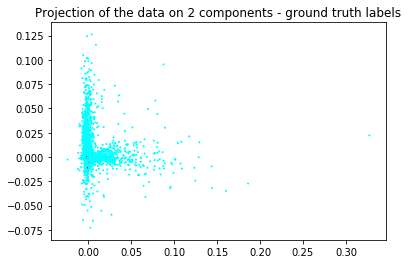

In [42]:
plt.scatter(X_transformed[:,1],X_transformed[:,0],[],color = colors)
plt.title("Projection of the data on 2 components - ground truth labels")

In [43]:
# create a list of colors
colors = []
for c in kmeans.labels_:
    if c==1:
        colors.append('blue')
    else:
        colors.append('orange')

Text(0.5,1,'Projection of the data on 2 components - kmeans labels')

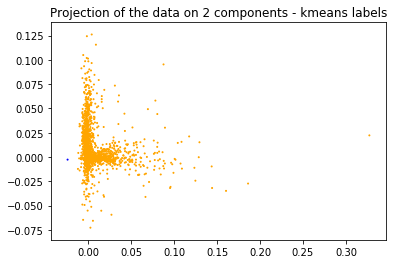

In [44]:
plt.scatter(X_transformed[:,1],X_transformed[:,0],[],color = colors)
plt.title("Projection of the data on 2 components - kmeans labels")

Few dimensions do not seem sufficient to separate the dataset.

### Supervised Prediction

In this competition we have the privilige to have annotated data. So let's use those labels. We are in fact trying to solve a classification problem: we want to build a classifier which correctly identifies whale calls.

`scikit learn` has many built-in classification algorithms. Random Forests is a general purpose nonlinear classification method, which usually works pretty well.

done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.9
  latest version: 4.5.8

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [46]:
from sklearn.ensemble import RandomForestClassifier

/Users/valentina/anaconda/envs/ohw_tutorial/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


We will split the dataset in two parts: a training set and a testing set.

In [47]:
X_train = X.T.iloc[:15000,:]
Y_train = np.array(labels['label'][X.columns][:15000])
X_test = X.T.iloc[15000:,:]
Y_test = np.array(labels['label'][X.columns][15000:])

In [48]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Evaluation

Ok, we fitted a classifier, but how should we evaluate performance? First let's look at the accuracy on the train dataset: it better be good!!!

In [49]:
# prediction on the training dataset
train_accuracy = 1 - np.sum(np.abs(clf.predict(X_train) - Y_train))/len(Y_train)
print('Accuracy on the train dataset is '+ str(train_accuracy))

Accuracy on the train dataset is 0.9562


But what we want to know is how the method performs on the test dataset, whose labels we have not seen in training.

In [50]:
# prediction on the testing dataset
test_accuracy = 1 - np.sum(np.abs(clf.predict(X_test)-Y_test))/len(Y_test)
print('Accuracy on the test dataset is '+ str(test_accuracy))

Accuracy on the test dataset is 0.8117333333333333


Ok, it is lower, as expected, but still decent.

Question: what will be the accuracy if we always claim there is no whale call?

Hint: what is the percentage of snippets with whale calls?

In [51]:
Y_test.sum()/len(Y_test)

0.2664

Other measures: [Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) - Area Under the Curve (ROC AUC)

The ROC curve allows explore how the algorithm performs for different decison thresholds.

In [52]:
from sklearn.metrics import roc_auc_score
y_score = clf.predict_proba(X_test)[:,1]
roc_auc_score(Y_test, y_score)


0.878497636131224

#### Are the low dimensional feautures better??? Which ones?

Let's use the low dimensional features.

In [53]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_transformed[:15000,:], np.array(labels['label'][X.columns][:15000]))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [54]:
X_transformed.shape

(30000, 5)

In [55]:
train_accuracy = 1 - np.sum(np.abs(clf.predict(X_transformed[:15000,:]) - labels['label'][X.columns][:15000]))/15000.
print('Accuracy on the train dataset is '+ str(train_accuracy))

Accuracy on the train dataset is 0.8098666666666667


In [56]:
test_accuracy = 1 - np.sum(np.abs(clf.predict(X_transformed[15000:,:]) - labels['label'][X.columns][15000:]))/15000.
print('Accuracy on the test dataset is '+ str(test_accuracy))

Accuracy on the test dataset is 0.7322666666666666


How can we improve:

* randomly split the train and test datasets

* perform true cross validation

* account for time shifting

* equalize spectrograms

* try other classifiers: gradient boosting, SVM

* ???


## Large Data Processing

What if we have many many such files???

* We can speed up the computation of the spectrograms by parallelizing this step by file.
* We will end up with a humongous features x samples array on which to run PCA.
* If we can load this array in RAM, we can apply randomized PCA on it.
* If not we can use dask to perform the PCA (SVD).

In [57]:
# put everything in one function
def process_file(filename):
    aiff = aifc.open(filename,'r')
    whale_strSig = aiff.readframes(aiff.getnframes())
    whale_array = np.fromstring(whale_strSig, np.short).byteswap()
    P, freqs, bins = mlab.specgram(whale_array, **params)
    return(P.ravel())

In [58]:
from dask import delayed
import dask.array as da

In [59]:
from scipy import linalg

In [60]:
process_file_dask = delayed(process_file)
# create delayed evaluations
lazy_values = [process_file_dask(filename) for filename in filenames]
# create a list of dask arrays
arrays = [da.from_delayed(lazy_value, shape=(7621,), dtype='float64') for lazy_value in lazy_values]

In [61]:
# stack them all into one array
stack = da.stack(arrays, axis=0)

In [62]:
## Do not execute those on jupyter hub

In [63]:
# execute the computation
# X = stack.compute()
# compute in ram
# u, s, vt = linalg.svd(X)

In [64]:
# compute out of core
# u, s, vt = da.linalg.svd(stack)

### References:
* https://github.com/jaimeps/whale-sound-classification